##### The Encoder-decoder goal is to build a candle classification dictionary for futher LLM
It encodes and decodes <b>normalized candles</b> as there is no goal yet to reproduce price move direction/distance or even correct candle height.
This is next step to be implemented with LLM-kind of model, where <i>candles will be considered as alphabet characters</i> and series of candles are words, sentences and chapters for price action poeme :-) 

In [3]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path



In [498]:
#Import NQ futures candles dataset
dataset = './data/nqh23_15sec.csv'
tick_data = './data/NQ 06-23.Last.csv'
if os.path.isfile(dataset):
    df1 = pd.read_csv(dataset)

else:
    header = ('date','last')
    df = pd.read_csv(tick_data, delimiter=';', usecols=[0,1], header=None, names=header)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d %H%M%S %f', utc = True)
    df1 = df.resample("15s", on = 'date',).ohlc()['last']
    df1.dropna(inplace=True)
    df1.to_csv(dataset)


df1.set_index('date',inplace=True)
df1.index.name = None
display(df1.head())
print(f"Candle dataset shape: {df1.shape}")


,open,high,low,close
2023-03-13 04:00:00+00:00,12177.25,12179.00,12177.25,12179.00
2023-03-13 04:00:15+00:00,12179.00,12179.25,12179.00,12179.25
2023-03-13 04:00:30+00:00,12181.25,12181.25,12180.25,12180.75
2023-03-13 04:00:45+00:00,12179.50,12179.75,12179.25,12179.75
2023-03-13 04:01:00+00:00,12180.00,12181.75,12180.00,12180.50


Candle dataset shape: (354167, 4)


In [16]:
# My own Normalisation function. the only reason I use them is I can easie reproduce them in TradingView Pinescript, 
# while e.g Pytorch nn.instanceNorm1d, gives sllughtly different result. But technically there is no differece which one to use here.
def MinMaxNorm(x: torch.Tensor, dim = None, shift = False):

    r'''MinMax Normalization function, normalize values in (0,1) range.

    dim - dimentions setting, 
    where None - for global normalization, 1 - for per instance normalizaton and 0 - per feature normalization
    shif = True shifts all values agains candle Open'''

    if dim == None:
        return (x - x.min())/(x.max() - x.min())
    elif dim == 1:
        if shift:
            norm_x = (torch.nan_to_num((x - x.min(dim).values.view(-1,1))/(x.max(dim).values - x.min(dim).values).view(-1,1),0))
            return  norm_x - norm_x[:,0].view(-1,1) 
        else:
            return torch.nan_to_num((x - x.min(dim).values.view(-1,1))/(x.max(dim).values - x.min(dim).values).view(-1,1),0)
        
    elif dim == 0:
        return (x - x.min(dim).values)/(x.max(dim).values - x.min(dim).values)

    

def StandardNorm(x: torch.Tensor, dim = None):

    r'''Standard Normalization function, normalize values in (0,1) range.

    dim - dimentions setting, 
    where None - for global normalization, 1 - for per instance normalizaton and 0 - per feature normalization'''

    if dim == None:
        return (x - x.mean())/(x.std())
    elif dim ==1:
        return (x - x.mean(dim).reshape(-1,1))/(x.std(dim).reshape(-1,1))
    else:
        return (x - x.mean(dim))/(x.std(dim))



In [499]:
# in addition to Loss control< good to use a candle decode accuracyEncode-Decode accuracy calculation function

def accuracy(actual:torch.Tensor, pred:torch.Tensor, precision):
    return (torch.isclose(actual, pred, precision, precision).sum().item()/ (pred.shape[0] * pred.shape[1]))


In [500]:
#pick 10K candles as traning sample and conver to torch tensor

candles_sample = torch.tensor(df1.iloc[:].values,dtype=torch.float)
candles_sample


tensor([[12177.2500, 12179.0000, 12177.2500, 12179.0000],
        [12179.0000, 12179.2500, 12179.0000, 12179.2500],
        [12181.2500, 12181.2500, 12180.2500, 12180.7500],
        ...,
        [14864.5000, 14866.0000, 14864.5000, 14866.0000],
        [14866.7500, 14867.0000, 14866.5000, 14866.5000],
        [14867.2500, 14867.2500, 14865.0000, 14866.2500]])

In [584]:
# Function which generate series of dots, reflecting price flow while a candle shapes.
# The assumption is that for GREEN candle the price moves as open->low->high->close 
# and for RED the price moves as open->high->low->close 
# Function returns a tensor with 30 priceing dots

def CandlePriceFlow(sample : torch.Tensor):
    cdl = sample.clone()
    step1 = torch.where(cdl[:,0] <= cdl[:,3], cdl[:,2], cdl[:,1])
    step2 = torch.where(cdl[:,0] <= cdl[:,3], cdl[:,1], cdl[:,2])
    #converting high-low sequence for green candles
    cdl[:,1] = step1
    cdl[:,2] = step2
    
    # create three lines for price flow: open-low, low-high, high-close (this is for green candle, for red is similar)

    y = torch.concatenate([cdl[:,:2],cdl[:,1:3],cdl[:,2:4]],dim=1)
    x = torch.zeros((1,6))
    for i in range(3):
        x[0,i*2:i*2+2] = torch.tensor([i*10,(i+1)*10])

    #create empty a and b variables tensors for linear equation a * x + b for for price move sloap.

    a = torch.zeros((len(y),3))
    b = torch.zeros((len(y),3))
    # calculate three sets of a,b variblesfor three price move sloap

    for i in range(3):
        a[:,i] = (y[:,i*2+1]-y[:,i*2]) * (x[:,i*2+1]-x[:,i*2]) ** -1
        b[:,i] = (x[:,i*2+1]*y[:,i*2] -  y[:,i*2+1]*x[:,i*2]) * (x[:,i*2+1]-x[:,i*2]) ** -1
    
    x = torch.arange(0,30,dtype=torch.float).reshape(3,-1)
    
    # calculate price  numbers, 10 for for each of price move sloap and merge in a single tensor with size [number_of_candles,30]
    
    return  torch.concat([a[:,0].view(-1,1) @ x[0].view(1,-1) + b[:,0].view(-1,1),
                a[:,1].view(-1,1) @ x[1].view(1,-1) + b[:,1].view(-1,1),
                a[:,2].view(-1,1) @ x[2].view(1,-1) + b[:,2].view(-1,1)],dim=1)

In [501]:
#normalize traning set of candles as encode-decode sample

candles_norm = MinMaxNorm((candles_sample),1)
candles_norm




tensor([[0.0000, 1.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000],
        [1.0000, 1.0000, 0.0000, 0.5000],
        ...,
        [0.0000, 1.0000, 0.0000, 1.0000],
        [0.5000, 1.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 0.0000, 0.5556]])

In [502]:
# Enc-Dec NN model definition. This is rather simple Linear with one hidden layer and Softmax activation 
# to get candles class codes (set of 10 candle features probabilities)
# Trained Encoder half of the model can be used later on for quick canldes classification.
# self.label is out put of the ecoder, which is indeed a candle class code

class CandleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
       
    #encoding layers
        self.seq1 = nn.Sequential(
            nn.Linear(4,16),
            nn.ReLU(),
            nn.Linear(16,2),
            nn.ReLU()
            )

    #decoding layers    
        self.seq2 = nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU(),
            nn.Linear(16,4),
            nn.Sigmoid()
        )
        

    def forward(self, x):
        self.label = (self.seq1(x))
        return self.seq2(self.label)


Epoch: 0 | Loss: 0.7058794498443604 | Accuracy: 0.02%

Epoch: 883 | Loss: 0.16059400141239166 | Accuracy: 49.62%


Text(0.5, 1.0, 'Traning accuracy')

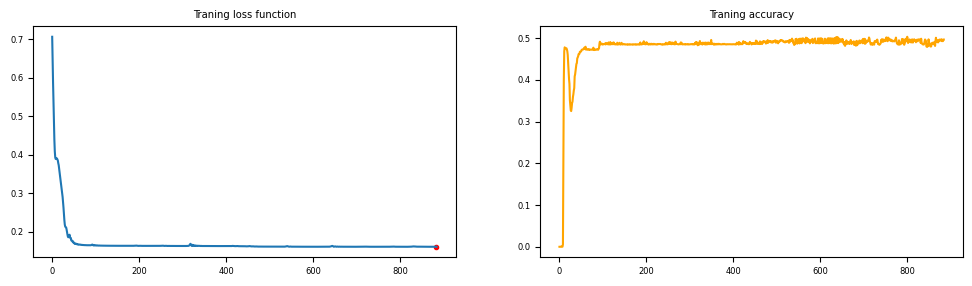

In [505]:
#Encode-Decode Traning loop

torch.manual_seed(2345163)
loss_plt = []
acc_plt = []
model0 = CandleClassifier()

epochs = 884
model0 = model0.to("cpu")
candles_norm = candles_norm.to('cpu')
loss_fn =  nn.BCELoss()
optimizer = torch.optim.Adam(model0.parameters(), lr = 0.04, weight_decay=1e-4) # Adam optimizer was choosen insted of SGD due convergency issues with SGD

      
for epoch in range(epochs):

    #set train mode
    model0.train()

    #forward pass
    out = model0(candles_norm)
    
    #loss and accuracy calculation
    loss = loss_fn(out, candles_norm)
    acc = accuracy(out, candles_norm, 1e-3)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #calculate and collect loss and accucary values through the traning fot further plot and print
    if epoch % 1 == 0:
        loss_plt.append(loss.item())
        acc_plt.append(acc)
    if epoch % (epochs/10) == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: %.2f" % (acc*100)+"%")
    #Break the traning loop in case the accuracy 99% is achieved    
    # if acc > 0.50 or loss < 0.37146:
    #     break


#adding final Loss and accucacy    
loss_plt.append(loss.item())
acc_plt.append(acc)
print(f"\nEpoch: {epoch} | Loss: {loss} | Accuracy: %.2f" % (acc*100)+"%")

#Plot loss function and accuracy change through the traning
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(loss_plt)
plt.scatter(x=loss_plt.index(min(loss_plt)),y=min(loss_plt),color='red', marker='.')
plt.title('Traning loss function')

plt.subplot(122)
plt.plot(acc_plt, color='orange')
plt.title('Traning accuracy')

In [506]:
loss_plt.index(min(loss_plt)),min(loss_plt), acc_plt.index(max(acc_plt)),max(acc_plt)

(883, 0.16059400141239166, 800, 0.5028538796669367)

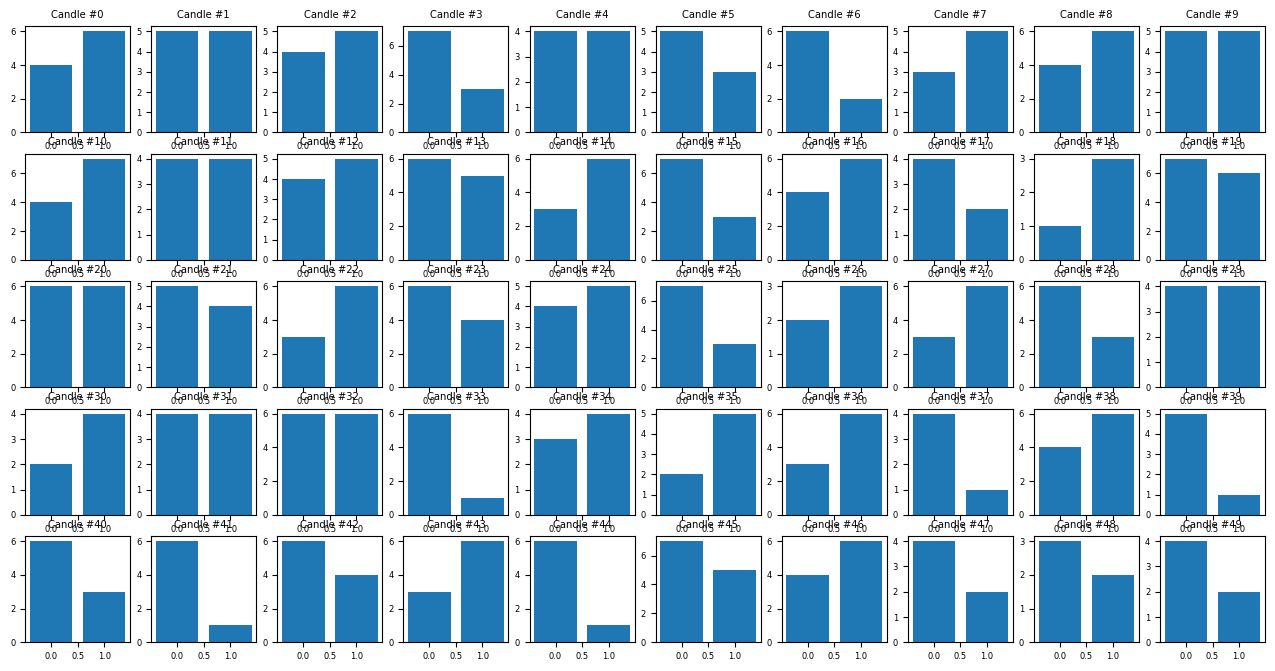

In [281]:
#plot example of 50 candles labels(classes) (kind of candle class code. )
#These candles are plotted in the next notebook cell

plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 6})
#y = torch.tensor(list(enumerate(model0.label[1000:1050].cpu().detach().numpy())))[:,1]
for i in range(0,50,1):

#    print(f"Candle {i}: {y[i].item(): .3f} | Candle {i+1}: {y[i+1].item(): .3f} | Candle {i+2}: {y[i+2].item(): .3f} | Candle {i+3}: {y[i+3].item(): .3f} | Candle {i+4}: {y[i+4].item(): .3f} ")
    
    plt.subplot(5,10,i+1)
    plt.title(f'Candle #{i}')
    x = torch.tensor(list(enumerate(model0.label[1000+i].cpu().detach().numpy())))[:,0]
    y = torch.round(torch.tensor(list(enumerate(model0.label[1000+i].cpu().detach().numpy())))[:,1])
    plt.bar(x,y)



In [ ]:
#Plot candle price flow
plt.figure(figsize=(16,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.title(f'Candle #{i}')
    plt.plot(candles_norm[1000+i].cpu().detach().numpy())
    plt.plot(out[1000+i].cpu().detach().numpy(), alpha=0.7)


In [18]:
##Function to plot candles from the dataset generated based on prediction
def plot_sample(sample):
    import plotly.graph_objects as go

    cdl_data = pd.DataFrame(sample, columns=('open','high','low','close') )

    fig = go.Figure(data=[go.Candlestick(x=cdl_data.index,
                    open=cdl_data['open'], high=cdl_data['high'],
                    low=cdl_data['low'], close=cdl_data['close'])
                        ])

    # fig.add_trace(
    #     go.Scatter(
    #         x=cdl_data.index,
    #         y=cdl_data['high'],
    #         mode= "text",
            
    #         text = cdl_data['class'],
    #         textposition = 'top center',
    #         textfont = {'size':8}))

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

In [507]:
#Plot candlestick charts
plot_sample(out[1000:1050].detach().numpy())
plot_sample(candles_sample[1000:1050])


In [508]:
labels = torch.round(model0.label.cpu().detach(),decimals=0)
uniq = torch.unique(labels,dim=0)
diag = torch.tensor([10.0,1])
code_list = {}
for i,code in enumerate((uniq @ diag.view(2,1)).numpy()):
    code_list[code.item()]= i
codes = (labels @ diag.view(2,1))
df1['codes'] = codes
df1.groupby('codes').sample()



,open,high,low,close,codes
2023-04-20 22:44:15+00:00,13081.00,13081.00,13081.00,13081.00,0.0
2023-04-19 23:09:45+00:00,13147.00,13147.50,13147.00,13147.00,12.0
2023-06-06 00:18:00+00:00,14561.00,14561.75,14560.75,14560.75,13.0
2023-05-15 10:25:00+00:00,13432.50,13433.25,13432.50,13432.75,21.0
2023-04-11 14:20:45+00:00,13085.75,13089.75,13085.25,13086.25,22.0
2023-04-10 00:04:00+00:00,13157.75,13158.25,13157.50,13157.50,23.0
2023-03-17 04:05:00+00:00,12721.00,12721.25,12720.75,12720.75,24.0
2023-05-03 22:09:30+00:00,13063.25,13064.00,13061.75,13061.75,25.0
2023-06-02 03:31:00+00:00,14503.00,14504.75,14503.00,14503.75,31.0
2023-05-30 14:10:00+00:00,14438.25,14442.75,14437.25,14438.75,32.0


In [509]:
df1['codes'] = df1['codes'].apply(lambda x : code_list[x])
df1


,open,high,low,close,codes
2023-03-13 04:00:00+00:00,12177.25,12179.00,12177.25,12179.00,29
2023-03-13 04:00:15+00:00,12179.00,12179.25,12179.00,12179.25,29
2023-03-13 04:00:30+00:00,12181.25,12181.25,12180.25,12180.75,28
2023-03-13 04:00:45+00:00,12179.50,12179.75,12179.25,12179.75,36
2023-03-13 04:01:00+00:00,12180.00,12181.75,12180.00,12180.50,3
...,...,...,...,...,...
2023-06-13 03:58:45+00:00,14865.00,14865.00,14864.50,14864.50,14
2023-06-13 03:59:00+00:00,14864.25,14865.00,14864.25,14865.00,29
2023-06-13 03:59:15+00:00,14864.50,14866.00,14864.50,14866.00,29
2023-06-13 03:59:30+00:00,14866.75,14867.00,14866.50,14866.50,6


In [573]:
plot_sample(MinMaxNorm((torch.tensor(df1.groupby('codes').sample().iloc[:,:4].values)),1))
